In [1]:
import math

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [2]:
# Read data using pandas
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

In [3]:
df.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0


In [4]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
# Data Cleaning
# Delete first three rows
df = df.drop([0,1,2], axis=0)

# Make first row the column headers
df = df.reset_index(drop=True)
df.columns = df.iloc[0]
df = df.drop([0], axis=0)
df = df.reset_index(drop=True)

# Rename all column headers
df.columns = ['City', 'Population', 'Violent Crime', 'Murder and Nonnegligent Manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny-Theft', 'Motor Vehicle Theft', 'Arson']


# Remove entire Unnamed: 4 or 'Rape revised defintion'
df = df.drop('Rape (revised definition)', axis=1)

# Remove null objects
df = df.drop([348, 349, 350], axis=0)
df = df.drop('Arson', axis=1)
df = df.dropna(how='all')

#Convert Columns from object to integer
df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

#Rename murder column to 'Murder'
df = df.rename(columns = {'Murder and Nonnegligent Manslaughter':'Murder'})

# Change name of Property Crime and Aggravated Assault so that it's one word
df['Propertycrime'] = df['Property Crime']
df = df.drop(columns=['Property Crime'])

df['Rape'] = df['Rape (legacy definition)']
df = df.drop(columns=['Rape (legacy definition)'])

df['Aggravated_Assault'] = df['Aggravated Assault']
df = df.drop(columns=['Aggravated Assault'])

In [6]:
# applies interquartile range calculation throughout whole data frame and then removes outlies
# define first and third quartile for every column
# calculate iqr for every column
# remove outliers for every column

    
# Calculate first and third quartile
first_quartile = df['Propertycrime'].describe()['25%']
third_quartile = df['Propertycrime'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df = df[df['Propertycrime'] < (third_quartile + 3 * iqr)]

In [7]:
df.head()

,City,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Motor Vehicle Theft,Propertycrime,Rape,Aggravated_Assault
0,Adams Village,1861,0,0,0,2,10,0,12,0,0
1,Addison Town and Village,2577,3,0,0,3,20,1,24,0,3
2,Akron Village,2846,3,0,0,1,15,0,16,0,3
4,Albion Village,6388,23,0,4,53,165,5,223,3,16
5,Alfred Village,4089,5,0,3,10,36,0,46,0,2


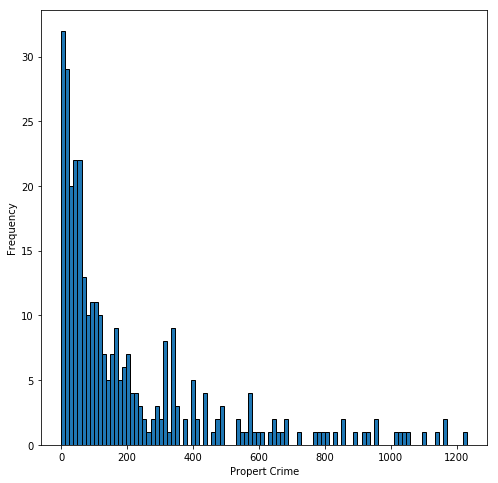

In [8]:
plt.figure(figsize=(8,8))
plt.hist(df['Propertycrime'], bins = 100, edgecolor='k')
plt.xlabel('Propert Crime')
plt.ylabel('Frequency')
plt.show()

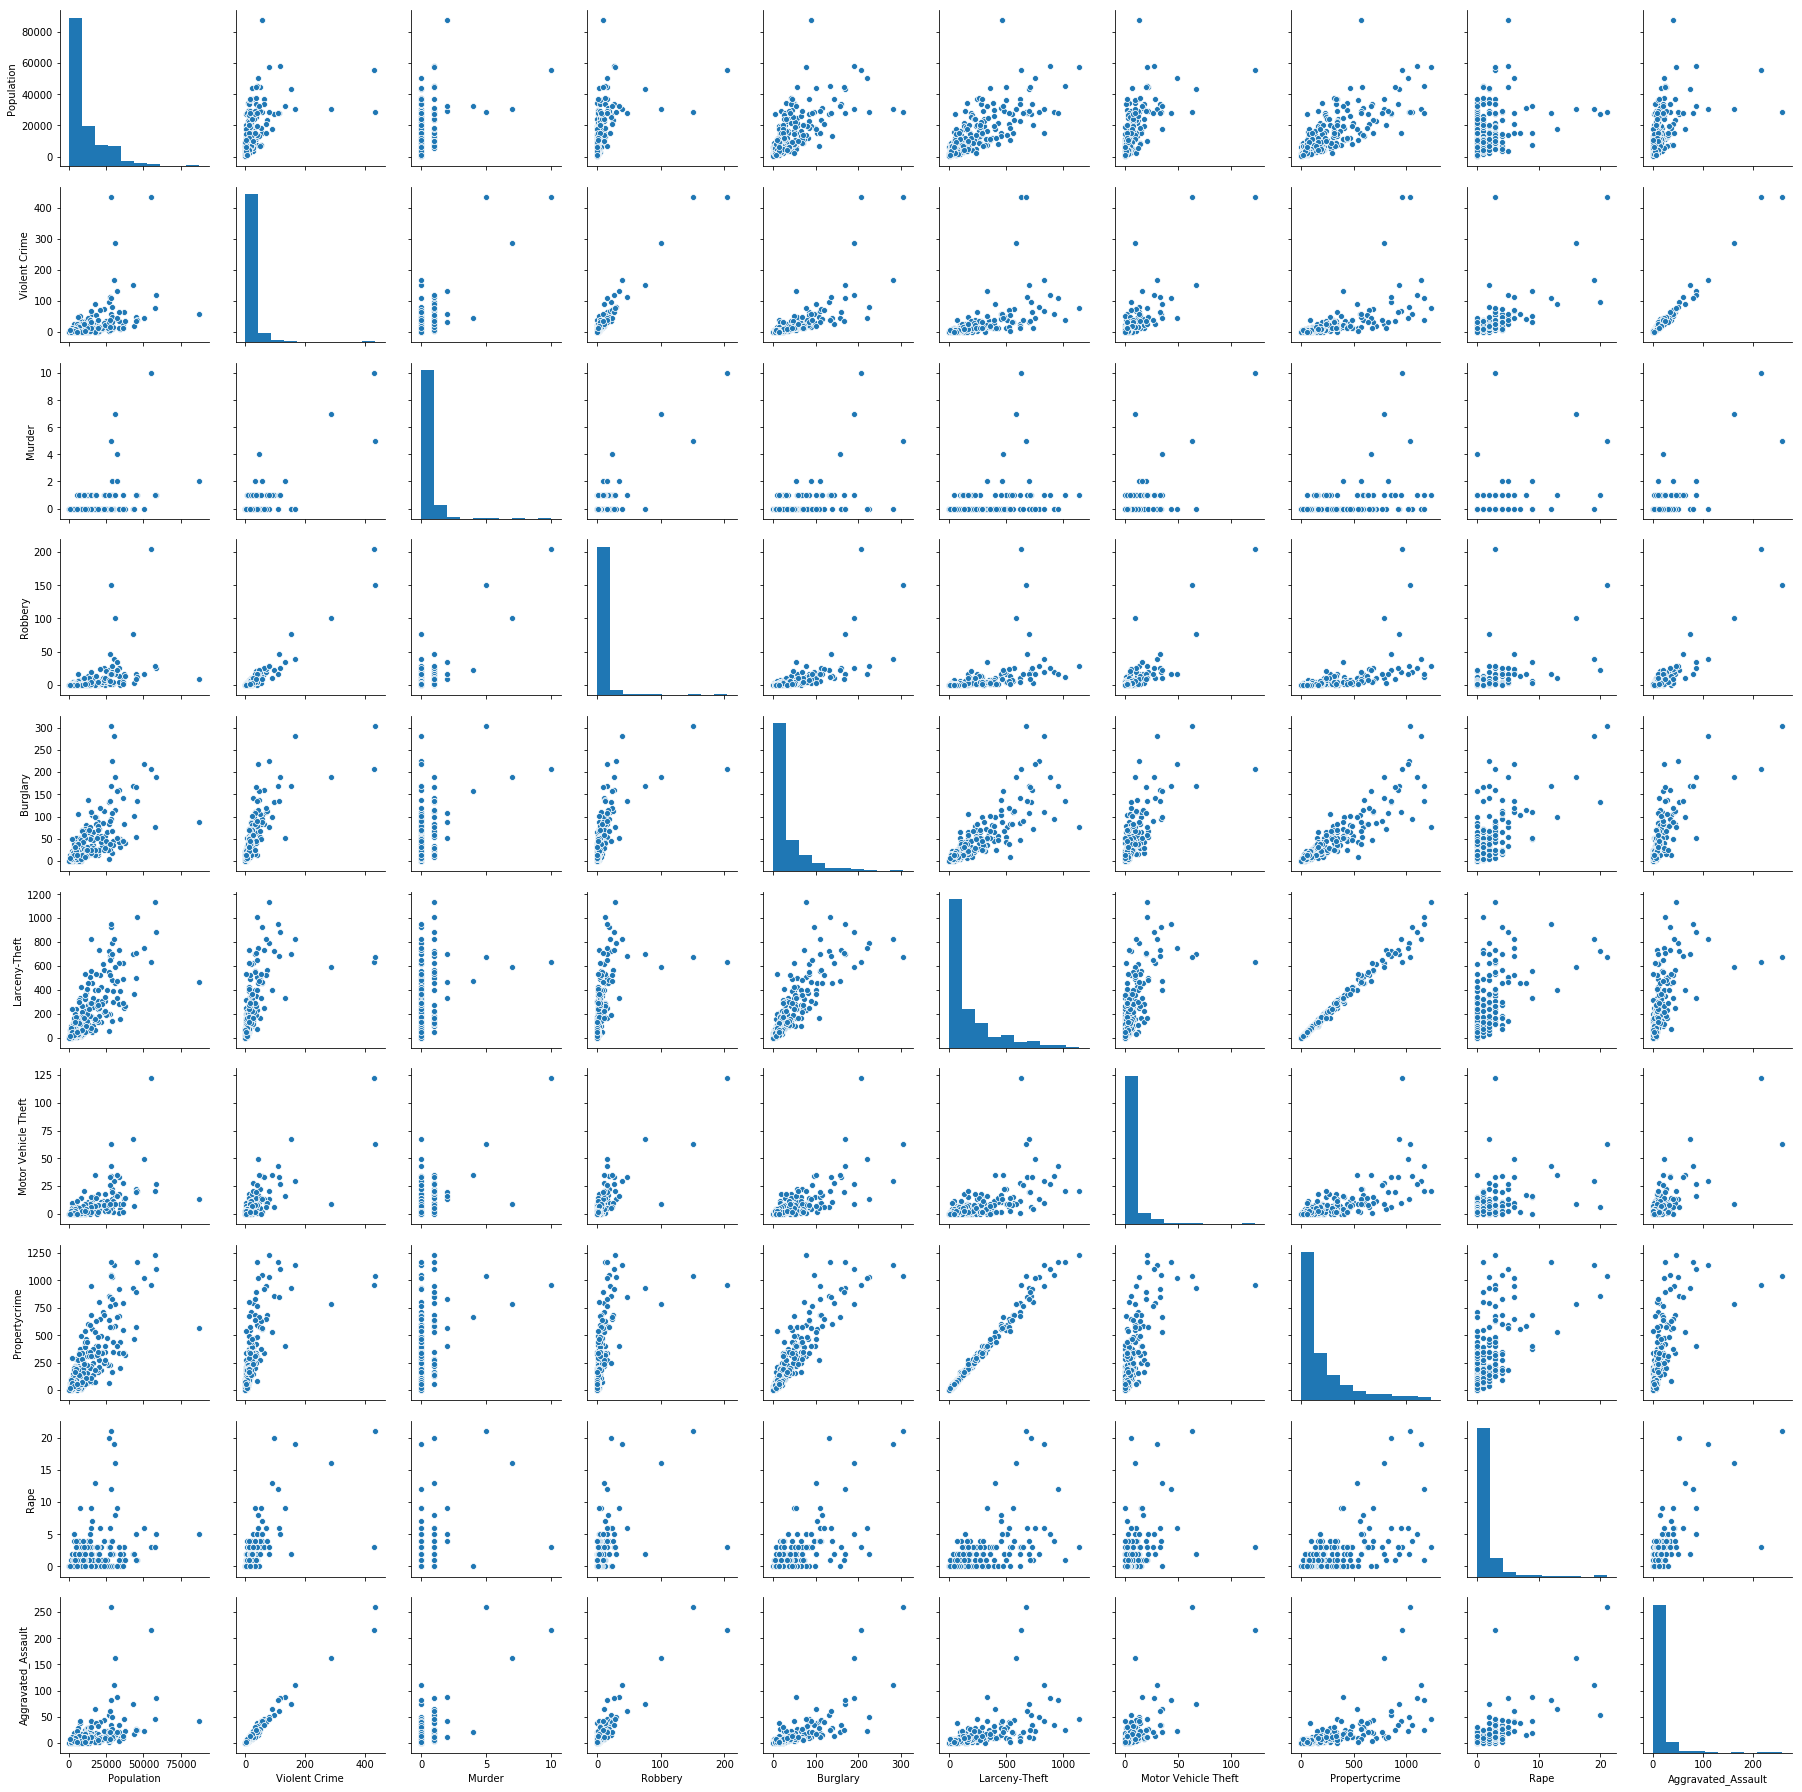

In [9]:
sns.pairplot(df)

In [10]:
# Create Features: Population^2, Murder binary, Robbery, binary
# More specifically, create binary categories for murder and robery
df['Population^2'] = df['Population']**2
df['Murder'] = np.where(df['Murder']>0, '1', '0')
df['Robbery_binary'] = np.where(df['Robbery']>0, '1', '0')
df['Aggravated_Assault'] = np.where(df['Aggravated_Assault']>0, '1', '0')
df['Violent Crime'] = np.where(df['Violent Crime']>0, '1', '0')
df['Rape'] = np.where(df['Rape']>0, '1', '0')
df['Robbery'] = np.where(df['Robbery']>0, '1', '0')
df['Burglary'] = np.where(df['Burglary']>0, '1', '0')
df['Larceny-Theft'] = np.where(df['Larceny-Theft']>0, '1', '0')
df['Motor Vehicle Theft'] = np.where(df['Motor Vehicle Theft']>0, '1', '0')
df['Propertycrime '] = np.where(df['Propertycrime']>0, '1', '0')


#Convert new columns to int
df[['Population', 'Violent Crime',
       'Murder', 'Rape',
       'Robbery', 'Aggravated_Assault', 'Propertycrime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder', 'Rape', 'Robbery', 'Aggravated_Assault', 'Propertycrime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

In [11]:
# Removing outliers seem largely inconsequential on the skew of the data as the medians tend to hover around 0 
# for most of the variables. Removing outliers, therefore, does not improve the skew of distributions.
# A more significant change may be to convert all variables to Binary Variables, given the fact that
# there are many 0 values in each variable any way.
# Based on the predictor of whether the certain type of crime occurs, or not, we may be able to gain more insight
# on predicting Murder.

In [12]:
df.head()

,City,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Motor Vehicle Theft,Propertycrime,Rape,Aggravated_Assault,Population^2,Robbery_binary,Propertycrime
0,Adams Village,1861,0,0,0,1,1,0,12,0,0,3463321,0,1
1,Addison Town and Village,2577,1,0,0,1,1,1,24,0,1,6640929,0,1
2,Akron Village,2846,1,0,0,1,1,0,16,0,1,8099716,0,1
4,Albion Village,6388,1,0,1,1,1,1,223,1,1,40806544,1,1
5,Alfred Village,4089,1,0,1,1,1,0,46,0,1,16719921,1,1


In [13]:
# Making all variables binary seem to result in incredibly inconsistent Rsquared values when testing on holdout groups
# however they score at nearly 99% on the test sample. This seems to be a sign of overfitting. Perhaps making
# some of the variables binary and leaving some as continuous will improve the consistency.

In [14]:
# Run Model
regr = linear_model.LinearRegression()
y = df['Propertycrime'].values.reshape(-1, 1)
x = df[['Population','Population^2', 'Murder', 'Robbery_binary']]
regr.fit(x,y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x,y))


Coefficients: 
 [[ 2.07895808e-02 -1.38796201e-07  1.11467925e+02  7.83319708e+01]]

Intercept: 
 [-41.0397189]

R-squared:
 0.6832928164894707


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [15]:
# Cross Validation test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print('With 30% holdout: ' + str(regr.fit(x_train, y_train).score(x_test, y_test)))
print('Testing on sample:' + str(regr.fit(x,y).score(x,y)))

With 30% holdout: 0.6535170681385611
Testing on sample:0.6832928164894707


In [16]:
# Cross-validation with mutliple folds
from sklearn.model_selection import cross_val_score

cross_val_score(regr, x, y, cv=5)

array([0.74615357, 0.57890397, 0.63237418, 0.38600084, 0.69893012])

In [17]:
# Test for significance in parameters
linear_formula = 'Propertycrime ~ Population+Population^2+Murder+Robbery_binary'

# Fit the model to our data using formula
lm = smf.ols(formula=linear_formula, data=df).fit()

In [18]:
lm.params

Intercept             -13.542
Robbery_binary[T.1]   105.757
Population              5.686
Population ^ 2         -5.673
Murder                103.412
dtype: float64

In [19]:
lm.pvalues

Intercept             0.313
Robbery_binary[T.1]   0.000
Population            0.176
Population ^ 2        0.177
Murder                0.001
dtype: float64

In [20]:
# Create PCA on the follwing variables: Burglary, Violent Crime, Aggravated_Assault, Larceny-Theft, Motor-Vehicle Theft, Robbery

# Standardize Data
features = ['Burglary', 'Violent Crime', 'Aggravated_Assault', 'Larceny-Theft']
x = df.loc[:, features].values

scaler = StandardScaler()

scaler.fit(x)

pd.DataFrame(data=x, columns=features).head()

# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

# Create Merged Data Frame
principalDf = pd.DataFrame(data = principalComponents, columns = ['principalcomponent_1', 'principalcomponent_2'])
principalDf['City'] = df['City']
merged_inner = pd.merge(left=df, right=principalDf, left_on='City', right_on='City')
df = merged_inner

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
# Run Model
regr = linear_model.LinearRegression()
y = df['Propertycrime'].values.reshape(-1, 1)
x = df[['Population','Population^2', 'Murder', 'Robbery_binary', 'principalcomponent_1', 'principalcomponent_2']]
regr.fit(x,y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x,y))


Coefficients: 
 [[ 2.06568195e-02 -1.46017489e-07  1.10836746e+02  7.99245987e+01
  -2.88162073e+01  3.37269487e+00]]

Intercept: 
 [-41.32748084]

R-squared:
 0.6829339740851383


In [22]:
# Cross Validation test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
print('With 30% holdout: ' + str(regr.fit(x_train, y_train).score(x_test, y_test)))
print('Testing on sample:' + str(regr.fit(x,y).score(x,y)))

With 30% holdout: 0.5463461950611375
Testing on sample:0.6829339740851383
